# Lab4. Training, Deploying and hosting custom model on SageMaker

In this lab, you will run your training job with SageMaker. You will use your CNN architecture and script that you build at Lab3. 

 ## Set up SageMaker environment

* **Plase note that the Tensorflow eager mode will be enabled by below code:**  
 tf.enable_eager_execution()

In [2]:
from PIL import Image
import json
import os
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.contrib.eager.python import tfe
from sagemaker.tensorflow import TensorFlow

tf.enable_eager_execution()

In [3]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::308961792850:role/service-role/AmazonSageMaker-ExecutionRole-20180531T094549
CPU times: user 156 ms, sys: 3.96 ms, total: 160 ms
Wall time: 186 ms


## Upload data to S3

* Upload files to S3
* It may take several minutes **(5 minutes for 10,000 images)**

In [5]:
bucket = sess.default_bucket() 
prefix = 'anpr'

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-308961792850


In [6]:
print('there are {:,} files in gen/cropped-imgs folder.'.format(len(os.listdir('gen/cropped-imgs'))))
print('there are {:,} files in gen/nums-tags folder.'.format(len(os.listdir('gen/nums-tags'))))
print('there are {:,} files in tf/tf-train folder.'.format(len(os.listdir('tf/tf-train'))))
print('there are {:,} files in tf/tf-train_annotation folder.'.format(len(os.listdir('tf/tf-train_annotation'))))
print('there are {:,} files in tf/tf-validation folder.'.format(len(os.listdir('tf/tf-validation'))))
print('there are {:,} files in tf/tf-validation_annotation folder.'.format(len(os.listdir('tf/tf-validation_annotation'))))

there are 10,000 files in gen/cropped-imgs folder.
there are 10,000 files in gen/nums-tags folder.
there are 8,000 files in tf/tf-train folder.
there are 8,000 files in tf/tf-train_annotation folder.
there are 2,000 files in tf/tf-validation folder.
there are 2,000 files in tf/tf-validation_annotation folder.


In [7]:
s3_train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'tf/tf-train')
s3_validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'tf/tf-validation')
s3_train_annotation = 's3://{}/{}/{}'.format(bucket, prefix, 'tf/tf-train_annotation')
s3_validation_annotation = 's3://{}/{}/{}'.format(bucket, prefix, 'tf/tf-validation_annotation')

In [8]:
%%time
!aws s3 cp tf/tf-train {s3_train_data} --recursive --include "*1_0.png" --include "*2_0.png" --include "*3_0.png" --include "*4_0.png" --include "*5_0.png" > /dev/null
!aws s3 cp tf/tf-train {s3_train_data} --recursive --include "*6_0.png" --include "*7_0.png" --include "*8_0.png" --include "*9_0.png" --include "*0_0.png" > /dev/null
!aws s3 cp tf/tf-train {s3_train_data} --recursive --include "*1_1.png" --include "*2_1.png" --include "*3_1.png" --include "*4_1.png" --include "*5_1.png" > /dev/null
!aws s3 cp tf/tf-train {s3_train_data} --recursive --include "*6_1.png" --include "*7_1.png" --include "*8_1.png" --include "*9_1.png" --include "*0_1.png" > /dev/null
!aws s3 cp tf/tf-validation {s3_validation_data} --recursive > /dev/null
!aws s3 cp tf/tf-train_annotation {s3_train_annotation} --recursive > /dev/null
!aws s3 cp tf/tf-validation_annotation {s3_validation_annotation} --recursive > /dev/null

CPU times: user 2.73 s, sys: 611 ms, total: 3.34 s
Wall time: 3min 43s


* Check upload results 

In [10]:
!aws s3 ls {s3_train_data}/ |wc -l
!aws s3 ls {s3_validation_data}/ |wc -l
!aws s3 ls {s3_train_annotation}/ |wc -l
!aws s3 ls {s3_validation_annotation}/ |wc -l

8000
2000
8000
2000


In [11]:
s3_output_location = 's3://{}/{}/tf-output'.format(bucket, prefix)

## Check data channels

Training data will be copied from S3 to Tensorflow container.  
Refer to the below directory paths.

### Test and validation data directories
1) In this notebook
- train images: './tf/tf-train'
- train annotations: './tf/tf-train_annotations'
- validation images: './tf/tf-validation'
- validation annotations: './tf/tf-validation_annotations'

2) S3
- train images: 's3://leonkang-datalake-seoul/anpr/tf/tf-train'
- train annotations: 's3://leonkang-datalake-seoul/anpr/tf/tf-validation'
- validation images: 's3://leonkang-datalake-seoul/anpr/tf/tf-train_annotations'
- validation annotations: 's3://leonkang-datalake-seoul/anpr/tf/tf-validation_annotations'

**3) Training container (Tensorflow container)**
- **train images: '/opt/ml/input/data/train/'**
- **train annotations: '/opt/ml/input/data/train_annotation/'**
- **validation images: '/opt/ml/input/data/validation/'**
- **validation annotations: '/opt/ml/input/data/validation_annotation/'**

In [12]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/png', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/png', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='application/json', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='application/json', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}


* Refer to API specs of SDK site
    * https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/README.rst
    * https://sagemaker.readthedocs.io/en/latest/using_tf.html
* Refer to the API document 
    * https://sagemaker.readthedocs.io/en/stable/sagemaker.tensorflow.html  
   (Note that checkpoint_path, training_steps, evaluation_steps, requirements_file args are not permitted when using Script Mode)

## Check the code of 'cnn_ocr.py' for entry_point
* Thins file will be passed as entry_point when defining Tensorflow Estimator
* Notice that **model() function and get_data_pair() function are exactly same** as Lab3
* Hperparameters are parsed from argparse.ArgumentParser() as they will **be passed as arguments of the python run command line script**.
* In the main function, input data are loaded from local directory **'/opt/ml/input/data/{...channel...}'** thru SM_CHANNEL_... parameters
* In the main function, output model is stored in **'/opt/ml/model'** directory 

In [13]:
#!cat cnn_ocr.py

```python
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.layers import concatenate
import os
import argparse

import json
from PIL import Image

import keras.backend as K
K.set_image_data_format('channels_last')
import tensorflow as tf

from tensorflow.contrib.eager.python import tfe

tf.enable_eager_execution()
tf.set_random_seed(0)

NUMS =['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
CHARS=['가', '나', '다', '라', '마', '거', '너', '더', '러', '머', '고', '노', '도', '로', '모', '구', '누', '두', '루', '무', 
       '버', '서', '어', '저', '처', '커', '터', '퍼', '보', '소', '오', '조', '초', '코', '토', '포', '부', '수', '우', '주', '추', '쿠', '투', '푸', '후', 
       '그', '느', '드', '르', '므', '브', '스', '으', '즈', '츠', '크', '트', '프', '흐',
       '바', '사', '아', '자', '차', '카', '타', '파', '하', '허', '호']
SPACE=[' ']
JOIN =NUMS + CHARS + SPACE
n_chr = len(JOIN)

def parse_args():
    
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script
    parser.add_argument('--epochs', type=int, default=100)
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--learning_rate', type=float, default=0.001)
    parser.add_argument('--verbose', type=int, default=1)
    
    # data directories
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))
    parser.add_argument('--train_annotation', type=str, default=os.environ.get('SM_CHANNEL_TRAIN_ANNOTATION'))
    parser.add_argument('--validation_annotation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION_ANNOTATION'))
    
    # model directory: we will use the default set by SageMaker, /opt/ml/model
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    
    return parser.parse_known_args()

def get_data_pair(train_dir, annotation_dir):
    t_jsns = os.listdir(annotation_dir)
    flg_first = True
    for i in t_jsns:
        ext = i.split('.')[1]
        if ext == 'json':
            with open(annotation_dir + '/' + i, "r") as jfile:
                jdata = json.load(jfile)
                # read image
                img=Image.open(train_dir + '/' + jdata['file']) 
                img = img.resize((128, 64))
                imgs = img if flg_first else np.append(imgs, img)
                # read license plate numbers
                n_ = np.array(jdata['nums'])
                Y_t = np.zeros((n_chr, 7))
                Y_t[n_, np.arange(7)] = 1
                Y_ = Y_t if (flg_first) else np.append(Y_, Y_t)
                flg_first = False
    digits= np.split(Y_.reshape([-1,7]), 7, axis=1)
    return imgs.reshape([-1, 128, 64, 1])/255., [i.reshape([-1,81]) for i in digits]

def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = tf.keras.Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = tf.keras.layers.ZeroPadding2D((2, 2))(X_input)

    # CONV0 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(48, (5, 5), strides = (1, 1), name = 'conv0')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn0')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool0')(X)

    # CONV1 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv1')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn1')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((1, 2), strides = (2, 2), name='max_pool1')(X)

    # CONV2 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv2')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn2')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool2')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = tf.keras.layers.Flatten()(X)

    #----------------------------------------------------------
    d1 = tf.keras.layers.Dense(81, activation='softmax', name='d1')(X)
    d2 = tf.keras.layers.Dense(81, activation='softmax', name='d2')(X)
    d3 = tf.keras.layers.Dense(81, activation='softmax', name='d3')(X)
    d4 = tf.keras.layers.Dense(81, activation='softmax', name='d4')(X)
    d5 = tf.keras.layers.Dense(81, activation='softmax', name='d5')(X)
    d6 = tf.keras.layers.Dense(81, activation='softmax', name='d6')(X)
    d7 = tf.keras.layers.Dense(81, activation='softmax', name='d7')(X)
    
    model = tf.keras.Model(inputs = X_input, 
                  outputs = [d1,d2,d3,d4,d5,d6,d7],
                  name='CNN_ANPR')

    return model

if __name__ == "__main__":

    args, _ = parse_args()
    print('args test: learning_rate = {}, batch_size = {}, epochs = {}'.format(args.learning_rate, args.batch_size, args.epochs))
    print(args)
    
    # change the path to use '/opt/ml/input/data/{channel}/...'
    t_imgs, t_annotations = get_data_pair(args.train, args.train_annotation)
    v_imgs, v_annotations = get_data_pair(args.validation, args.validation_annotation)
    
    input_shape = (128,64,1)
    model_k = model(input_shape)
        
    # use hyperparameters ex) args.learning_rate
    model_k.compile(optimizer=tf.train.AdamOptimizer(args.learning_rate), 
            loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy',
                   'categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],
            metrics = ["accuracy"])
        
    # use hyperparameters ex) args.epochs, args.batch_size, etc.
    model_k.fit(t_imgs, [i.reshape([-1,81]) for i in t_annotations], 
        validation_data=(v_imgs, [i.reshape([-1,81]) for i in v_annotations]), 
        epochs=args.epochs, batch_size=args.batch_size, verbose=args.verbose)
        
    scores = model_k.evaluate(v_imgs, [i for i in v_annotations], batch_size=args.batch_size, verbose=1, sample_weight=None)
    print("scores: ", scores)
    
    # save checkpoint for locally loading in notebook
    saver = tfe.Saver(model_k.variables)
    saver.save(args.model_dir + '/weights.ckpt')
    
    # create a separate SavedModel for deployment to a SageMaker endpoint with TensorFlow Serving
    tf.contrib.saved_model.save_keras_model(model_k, args.model_dir)
            
```

## Run training job
* **This time, we will run 30 epochs. (It may take around 15 minutes)**
* Note that we use p3.2xlarge instance, which will shorten our training time with GPU. 
* To see the detailed message of training job, set the verobose to 1(true).

In [14]:
model_dir = '/opt/ml/model'
train_instance_type='ml.p3.2xlarge'
hyperparameters = {'epochs': 30, 
                   'batch_size': 128,
                   'learning_rate': 0.001,
                   'verbose': 0}

In [15]:
ocr_estimator = TensorFlow(entry_point='cnn_ocr.py',
                             role=role,
                             model_dir=model_dir,
                             hyperparameters=hyperparameters,
                             train_instance_count=1,
                             train_instance_type=train_instance_type,
                             framework_version='1.12', 
                             py_version='py3')

* Run your trining job.
* You will find the below command from the job log.  
```/usr/bin/python cnn_ocr.py --batch_size 128 --epochs 30 --learning_rate 0.001 --model_dir /opt/ml/model --verbose 0```

In [16]:
%%time
ocr_estimator.fit(data_channels, logs=True)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-308961792850
INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-scriptmode-2019-06-06-08-57-04-100


2019-06-06 08:57:04 Starting - Starting the training job...
2019-06-06 08:57:07 Starting - Launching requested ML instances......
2019-06-06 08:58:15 Starting - Preparing the instances for training...
2019-06-06 08:59:05 Downloading - Downloading input data...............
2019-06-06 09:01:35 Training - Downloading the training image..
2019-06-06 09:01:43,570 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-06-06 09:01:43,978 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "validation_annotation": "/opt/ml/input/data/validation_annotation",
        "train_annotation": "/opt/ml/input/data/train_annotation",
        "validation": "/opt/ml/input/data/validation",
        "train": "/opt/ml/input/data/train"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
  

* Check the model name that training job just created
* Check the model file that training job just created

In [18]:
print(ocr_estimator.output_path)
print(ocr_estimator.model_data)

!aws s3 ls {ocr_estimator.model_data}

s3://sagemaker-us-east-1-308961792850/
s3://sagemaker-us-east-1-308961792850/sagemaker-tensorflow-scriptmode-2019-06-06-08-57-04-100/output/model.tar.gz
2019-06-06 09:08:17   37868124 model.tar.gz


## Deploy the model and inference Test

* Now, let's deploy our model into SageMaker's inference hosting environment 

In [19]:
predictor = ocr_estimator.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge',
                                 accelerator_type='ml.eia1.medium')

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-scriptmode-2019-06-06-08-57-04-100
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-scriptmode-2019-06-06-08-57-04-100


----------------------------------------------------------------------------------------!

* Check the result of deploy

In [20]:
predictor.endpoint

'sagemaker-tensorflow-scriptmode-2019-06-06-08-57-04-100'

## Test data

* Prepare character list and test images

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
NUMS =['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
CHARS=['가', '나', '다', '라', '마', '거', '너', '더', '러', '머', '고', '노', '도', '로', '모', '구', '누', '두', '루', '무', 
       '버', '서', '어', '저', '처', '커', '터', '퍼', '보', '소', '오', '조', '초', '코', '토', '포', '부', '수', '우', '주', '추', '쿠', '투', '푸', '후', 
       '그', '느', '드', '르', '므', '브', '스', '으', '즈', '츠', '크', '트', '프', '흐',
       '바', '사', '아', '자', '차', '카', '타', '파', '하', '허', '호']
SPACE=[' ']
JOIN =NUMS + CHARS + SPACE
n_chr = len(JOIN)

In [23]:
test_imgs = os.listdir('tf/tf-validation')

* Check the prediction of 10 sample pairs of images

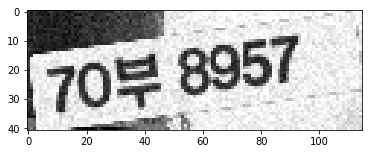

0
['7', '8', '무', '8', '9', '5', '7']


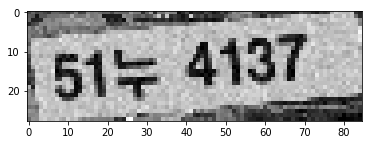

1
['5', '1', '누', '4', '1', '3', '7']


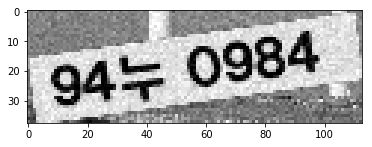

2
['9', '4', '수', '0', '9', '8', '4']


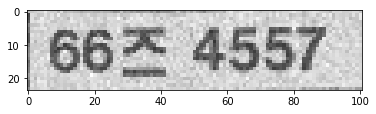

3
['5', '6', '즈', '4', '5', '5', '7']


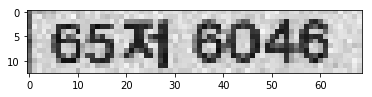

4
['0', '5', '저', '5', '8', '4', '6']


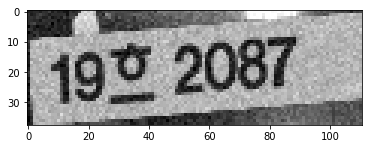

5
['1', '9', '호', '2', '0', '9', '7']


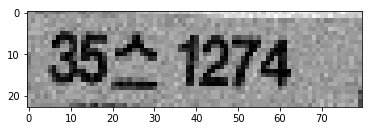

6
['3', '5', '스', '1', '2', '7', '4']


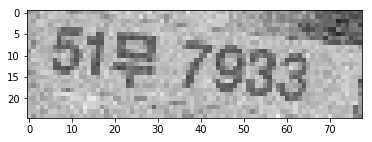

7
['5', '1', '부', '7', '9', '3', '3']


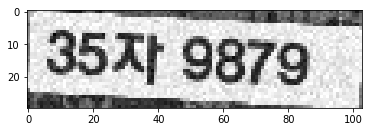

8
['3', '5', '자', '9', '8', '7', '9']


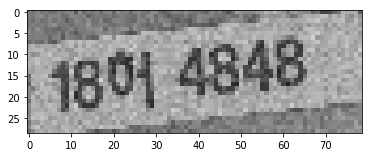

9
['1', '8', '허', '4', '8', '4', '8']


In [26]:
for i in range(10):
    val_img = Image.open('tf/tf-validation/' + test_imgs[i])
    val_img_np = np.array(val_img.resize((128,64)))
    input = {
      'instances': val_img_np.reshape([1,128,64,1])/255.
    }
    prediction = predictor.predict(input)
    plt.imshow(val_img)
    plt.show()
    print(i)
    digits = [JOIN[np.argmax(prediction['predictions'][0]['d1'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d2'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d3'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d4'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d5'])],  
              JOIN[np.argmax(prediction['predictions'][0]['d6'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d7'])]]
    print(digits)

## Endpoint API test

* You may invoke SageMaker endpoint from business application as below:

In [27]:
import boto3
from sagemaker.predictor import json_serializer, json_deserializer, RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON
runtime = boto3.Session().client('runtime.sagemaker')
tf_endpoint = predictor.endpoint

In [28]:
api_predictor = RealTimePredictor(endpoint=tf_endpoint, sagemaker_session=sess, serializer=json_serializer,
                                content_type=CONTENT_TYPE_JSON, accept=CONTENT_TYPE_CSV)
api_response = json.loads(api_predictor.predict(input))
print(JOIN[np.argmax(api_response['predictions'][0]['d1'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d2'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d3'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d4'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d5'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d6'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d7'])] )

18허4848


## Test the trainned model in local (Optional)
Let's extport your trained model from S3 and deploy it to local (this notebook). 

* Copy trainned model from S3 to ./model folder

In [29]:
#!rm -Rf model
!aws s3 cp {ocr_estimator.model_data} ./model/model.tar.gz --region {sess.boto_region_name}

download: s3://sagemaker-us-east-1-308961792850/sagemaker-tensorflow-scriptmode-2019-06-06-08-57-04-100/output/model.tar.gz to model/model.tar.gz


* Extract the model file and see the components

In [30]:
!tar -xvzf ./model/model.tar.gz -C ./model

weights.ckpt.data-00000-of-00001
checkpoint
weights.ckpt.index
1559812084/
1559812084/saved_model.pb
1559812084/assets/
1559812084/assets/saved_model.json
1559812084/variables/
1559812084/variables/checkpoint
1559812084/variables/variables.index
1559812084/variables/variables.data-00000-of-00001


* Define model architecture locally (same as Lab3)

In [31]:
def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = tf.keras.Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = tf.keras.layers.ZeroPadding2D((2, 2))(X_input)

    # CONV0 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(48, (5, 5), strides = (1, 1), name = 'conv0')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn0')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool0')(X)

    # CONV1 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv1')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn1')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((1, 2), strides = (2, 2), name='max_pool1')(X)

    # CONV2 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv2')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn2')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool2')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = tf.keras.layers.Flatten()(X)
    #----------------------------------------------------------
    d1 = tf.keras.layers.Dense(81, activation='softmax', name='d1')(X)
    d2 = tf.keras.layers.Dense(81, activation='softmax', name='d2')(X)
    d3 = tf.keras.layers.Dense(81, activation='softmax', name='d3')(X)
    d4 = tf.keras.layers.Dense(81, activation='softmax', name='d4')(X)
    d5 = tf.keras.layers.Dense(81, activation='softmax', name='d5')(X)
    d6 = tf.keras.layers.Dense(81, activation='softmax', name='d6')(X)
    d7 = tf.keras.layers.Dense(81, activation='softmax', name='d7')(X)
    
    model = tf.keras.Model(inputs = X_input, 
                  outputs = [d1,d2,d3,d4,d5,d6,d7],
                  name='CNN_ANPR')

    return model

* Read and retore model from downloaded checkpoint

In [32]:
tf.keras.backend.clear_session()

local_model = model((128,64,1))
saver = tfe.Saver(local_model.variables)
saver.restore('model/weights.ckpt')

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from model/weights.ckpt


INFO:tensorflow:Restoring parameters from model/weights.ckpt


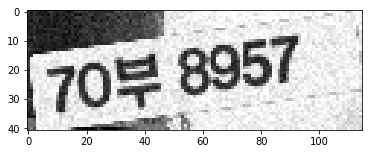

['7', '8', '무', '8', '9', '5', '7']


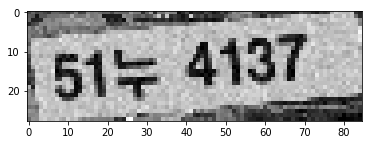

['5', '1', '누', '4', '1', '3', '7']


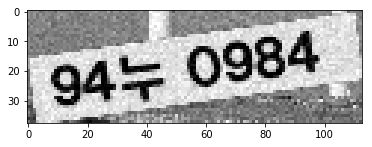

['9', '4', '수', '0', '9', '8', '4']


In [33]:
for i in range(3):
    val_img = Image.open('tf/tf-validation/' + test_imgs[i])
    val_img_np = np.array(val_img.resize((128,64)))
    prediction = local_model.predict(val_img_np.reshape([1,128,64,1])/255.)
    plt.imshow(val_img)
    plt.show()
    digits = [JOIN[np.argmax(prediction[0][0])], 
              JOIN[np.argmax(prediction[1][0])], 
              JOIN[np.argmax(prediction[2][0])], 
              JOIN[np.argmax(prediction[3][0])], 
              JOIN[np.argmax(prediction[4][0])], 
              JOIN[np.argmax(prediction[5][0])], 
              JOIN[np.argmax(prediction[6][0])]]
    print(digits)

* You may utilize above code to build your own inference environment

## Going further
You must not be satisfied with the results yet. There are still a lot of misclassification. (In the final test results, character '누' is recongnized as '수'.)  
We may further refine our model by the following ways:
* Adding more training images and more epochs
* Adding real world license plate images
* Changing an architecture to another structure (ex: CNN + LSTM)
* Combining Object detection and this OCR model into one CNN architecture (Usually, end-to-end approach needs more training data)
    
In our case, adding more training data is the first improvement we can try. Below is the result that I added more training data and tested with 100,000 images. You can see the result was improved with more training data.

<br />
  
<img src='imgs/finalresult.png' stype='width:600px;'/>

## Delete Endpoint

In [34]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: sagemaker-tensorflow-scriptmode-2019-06-06-08-57-04-100


## Next step
Thank you for your participating.   
**Don't forget to delete resources**(Any endpoints, Notebook instance, and S3 bucket) as a final step.